In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import copy
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import transformers
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)

In [5]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1126)

In [6]:
train = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


1
61


(array([9.9080e+03, 1.6276e+04, 7.1970e+03, 7.2500e+02, 8.1000e+01,
        3.0000e+01, 1.3000e+01, 8.0000e+00, 4.0000e+00, 8.0000e+00]),
 array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49., 55., 61.]),
 <BarContainer object of 10 artists>)

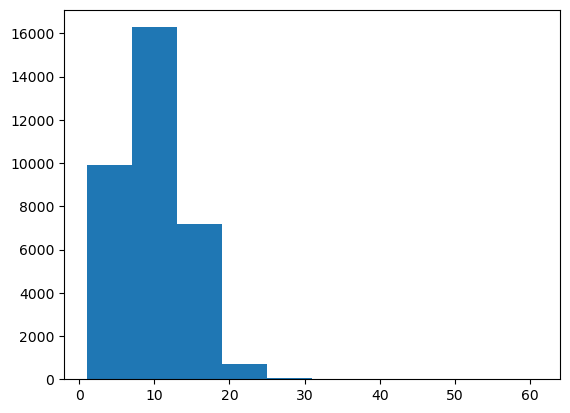

In [7]:
titles_length = train.title.apply(lambda x: len(x.split(" "))).to_numpy()
print(titles_length.min())
print(titles_length.max())

plt.hist(titles_length)

In [8]:
class CFG:
    DistilBERT = True # if set to False, BERT model will be used
    bert_hidden_size = 768
    
    batch_size = 64
    epochs = 30
    num_workers = 2
    learning_rate = 1e-5 #3e-5
    scheduler = "ReduceLROnPlateau"
    step = 'epoch'
    patience = 2
    factor = 0.8
    dropout = 0.5
    model_path = "/kaggle/working"
    max_length = 30
    model_save_name = "model.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [9]:
if CFG.DistilBERT:
    model_name = 'cahya/distilbert-base-indonesian'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    bert_model = DistilBertModel.from_pretrained(model_name)
else:
    model_name = 'cahya/bert-base-indonesian-522M'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
text = train.title.values[np.random.randint(0, len(train) - 1, 1)[0]]

print(f'Text of the title: {text}')
encoded_input = tokenizer(text, return_tensors = 'pt')
print(f"Input tokens: {encoded_input['input_ids']}")
decoded_input = tokenizer.decode(encoded_input["input_ids"][0])
print(f"Decoded tokens: {decoded_input}")
output = bert_model(**encoded_input)
print(f"last layer's output shape: {output.last_hidden_state.shape}")

Text of the title: Malia Dress by Wanoja/gamis wanoja/gamis supernova
Input tokens: tensor([[    3, 11914,  1007, 20990,  1018,  5536,  2727,  7938,    18,  3593,
          1511,  2727,  7938,    18,  3593,  1511, 23423,     1]])
Decoded tokens: [CLS] malia dress by wanoja / gamis wanoja / gamis supernova [SEP]
last layer's output shape: torch.Size([1, 18, 768])


In [11]:
encoded_input

{'input_ids': tensor([[    3, 11914,  1007, 20990,  1018,  5536,  2727,  7938,    18,  3593,
          1511,  2727,  7938,    18,  3593,  1511, 23423,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
lbl_encoder = LabelEncoder()
train.loc[:, 'label_code'] = lbl_encoder.fit_transform(train.label_group)
NUM_CLASSES = train.label_code.nunique()

In [13]:
train.head()

,posting_id,image,image_phash,title,label_group,label_code
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,666
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,7572
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,6172
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,10509
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,9425


In [14]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, mode = "train", max_length = None):
        self.dataframe = dataframe
        self.mode = mode
        if mode != 'test':
            self.targets = dataframe.label_code.values
        
        texts = list(dataframe.title.apply(lambda o: str(o)).values)
        self.encodings = tokenizer(texts, padding = True, truncation = True, 
                                   max_length = max_length)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(values[idx]) for key, values in self.encodings.items()}
        
        if self.mode != 'test':
            item['labels'] = torch.tensor(self.targets[idx]).long()
            
            return item
    
    def __len__(self):
        return len(self.dataframe)

In [29]:
dataset = TextDataset(train.sample(1000), tokenizer, max_length = CFG.max_length)
dataloader = DataLoader(dataset, batch_size = CFG.batch_size, 
                        num_workers = CFG.num_workers, shuffle = True)
batch = next(iter(dataloader))
print(batch)

{'input_ids': tensor([[    3,  2556,  3357,  ...,     2,     2,     2],
        [    3, 21862,  1013,  ...,     2,     2,     2],
        [    3, 25508,  1013,  ...,     2,     2,     2],
        ...,
        [    3,  3342, 23755,  ...,     2,     2,     2],
        [    3, 12352,    21,  ...,     2,     2,     2],
        [    3, 25713, 25508,  ...,     2,     2,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([ 2002, 10868,  2392,  1000,  5594,  2289, 10194, 10198,  1597, 10854,
         8566,  9633,  1754,  9923,  9218,  3193, 10030,  9490,  1640, 10628,
         1410,  6088,  5494,  9353,  2632,  5747,  1103,  2689,  3041,  8297,
          623,  8954,   297,  5246,  7809,  3255,   517,  1274, 10450,  8443,
         8952,  4633,  3981,  6349,  2267,  1831,   405, 10379, 

In [30]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

In [31]:
class Model(nn.Module):
    def __init__(self, bert_model, num_classes = NUM_CLASSES, 
                 last_hidden_size = CFG.bert_hidden_size):
        super().__init__()

        self.bert_model = bert_model
        self.arc_margin = ArcMarginProduct(last_hidden_size, num_classes)
    
    def get_bert_features(self, batch):
        output = self.bert_model(batch['input_ids'], batch['attention_mask'])   
        last_hidden_state = output.last_hidden_state
        CLS_token_state = last_hidden_state[:, 0, :]
        
        return CLS_token_state
    
    def forward(self, batch):
        CLS_token_state = self.get_bert_features(batch)
        output = self.arc_margin(CLS_token_state, batch['labels'])
        
        return output

In [32]:
class AvgMeter:
    def __init__(self, name = "Metric"):
        self.name = name
        self.reset()
    
    def reset(self):
        self.avg, self.sum, self.count = [0] * 3
        
    def update(self, val, count = 1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count
    
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        
        return text

In [33]:
def one_epoch(model, criterion, loader, optimizer = None, lr_scheduler = None, 
              mode = "train", step = "batch"):
    loss_meter = AvgMeter()
    acc_meter = AvgMeter()
    tqdm_object = tqdm(loader, total = len(loader))
    
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        preds = model(batch)
        loss = criterion(preds, batch['labels'])
        
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step == "batch":
                lr_scheduler.step()
        
        count = batch['input_ids'].size(0)
        loss_meter.update(loss.item(), count)
        accuracy = get_accuracy(preds.detach(), batch['labels'])
        acc_meter.update(accuracy.item(), count)
        
        if mode == "train":
            tqdm_object.set_postfix(train_loss = loss_meter.avg, accuracy = acc_meter.avg, 
                                    lr = get_lr(optimizer))
        else:
            tqdm_object.set_postfix(train_loss = loss_meter.avg, accuracy = acc_meter.avg)
        
    return loss_meter, acc_meter

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def get_accuracy(preds, targets):
    preds = preds.argmax(dim = 1)
    acc = (preds == targets).float().mean()
    
    return acc

In [34]:
def train_eval(epochs, model, train_loader, valid_loader, 
               criterion, optimizer, lr_scheduler = None):
    best_loss = float("inf")
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print("*" * 30)
        print(f"Epoch {epoch + 1}")
        current_lr = get_lr(optimizer)
        
        model.train()
        train_loss, train_acc = one_epoch(model, criterion, train_loader, optimizer, 
                                          lr_scheduler, mode = "train", step = CFG.step)
        
        model.eval()
        with torch.no_grad():
            valid_loss, valid_acc = one_epoch(model, criterion, valid_loader, optimizer = None, 
                                              lr_scheduler = None, mode = "valid")
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{CFG.model_path}/{CFG.model_save_name}')
            print("Save best model!")
            
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(valid_loss.avg)
            
            if current_lr != get_lr(optimizer):
                print("Loading best model weights")
                model.load_state_dict(torch.load(f'{CFG.model_path}/{CFG.model_save_name}', 
                                                map_location = CFG.device))
        print("*" * 30)

In [35]:
train_df, valid_df = train_test_split(train, test_size = 0.33, random_state = 1126, 
                                     stratify = train['label_code'])
train_dataset = TextDataset(train_df, tokenizer, max_length = CFG.max_length)
train_loader = DataLoader(train_dataset, batch_size = CFG.batch_size, 
                        num_workers = CFG.num_workers, shuffle = True)
valid_dataset = TextDataset(valid_df, tokenizer, max_length = CFG.max_length)
valid_loader = DataLoader(valid_dataset, batch_size = CFG.batch_size, 
                        num_workers = CFG.num_workers, shuffle = False)

In [ ]:
model = Model(bert_model).to(CFG.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.learning_rate)

if CFG.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min",
                                                              factor = CFG.factor, 
                                                              patience = CFG.patience)

train_eval(CFG.epochs, model, train_loader, valid_loader, criterion, optimizer, lr_scheduler)

******************************
Epoch 1


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 2


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 3


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 4


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 5


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 6


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Save best model!
******************************
******************************
Epoch 7


  0%|          | 0/359 [00:00<?, ?it/s]